# Relax Inc. Challenge

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user adoption .

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

sns.set()
%load_ext watermark
%watermark

2019-04-24T23:33:19

CPython 2.7.15
IPython 5.8.0

compiler   : MSC v.1500 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


Import Data

In [2]:
users_df = pd.read_csv('takehome_users.csv',
                       parse_dates=['creation_time'])

user_engagement_df = pd.read_csv('takehome_user_engagement.csv',
                                 parse_dates=['time_stamp'])

Let's take a look at the data

In [3]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


The last session times are problematic to convert, since there are some NaN values

In [5]:
users_df.loc[0, 'last_session_creation_time']

1398138810.0

In [6]:
datetime.utcfromtimestamp(users_df.loc[0, 'last_session_creation_time']).strftime('%Y-%m-%d %H:%M:%S')

'2014-04-22 03:53:30'

Creation source is a good candidate for a dummy var

In [7]:
users_df['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [8]:
len(users_df[(users_df['creation_source'] == 'GUEST_INVITE') | (users_df['creation_source'] == 'ORG_INVITE')])

6417

In [9]:
users_df['org_id'].unique()

array([ 11,   1,  94, 193, 197,  37,  74, 302, 318,  69, 130, 254,   0,
       175, 211,   2,  58,  54,   7,   6, 123,  81,  56, 134,  92, 251,
       283,  98, 401,  33,  59, 109, 276, 208, 332,  64, 235,  63,  14,
         4, 127,  32, 224, 304,  61,  51, 229,  88, 325, 150, 347, 203,
        21, 409, 215, 141,   5, 107, 184, 310, 367, 389,  89, 242,  68,
        16,  49, 185,  91, 172,   8,  43, 249,  26, 139,  70,  10, 252,
        53, 119,   3, 196, 335, 375, 303, 307,  25, 370,  83,  27, 306,
       118, 295,  19, 301, 100, 112, 263,  39,  12,  86, 402,  42, 103,
       373, 268,  30, 406,  48, 313,   9, 138, 261,  35, 264,  95,  55,
        60, 234,  28, 410, 170, 374,  15,  17, 364,  62, 244, 342, 225,
       121, 255, 411, 217, 165, 415, 104, 329, 278, 116, 151, 290, 200,
       187, 122, 353, 135, 328,  36,  13, 341, 349, 198, 153, 108,  77,
       142, 275, 176,  87, 191, 102, 245, 154, 218, 385,  76, 321, 159,
       371,  50,  75, 333, 137, 292, 286, 131, 178, 213, 376, 36

In [10]:
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [11]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


The point of this column is to sum it, since there are only 1s in it.

In [12]:
user_engagement_df.visited.unique()

array([1], dtype=int64)

### Data Cleaning

Fix last session timestamps.

The first try didn't work. All dates are in 1970

In [13]:
#users_df.loc[:, 'last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])

In [14]:
users_df.loc[users_df['last_session_creation_time'].notna(), 'last_session_creation_time'] = \
    [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') for ts in users_df.loc[users_df['last_session_creation_time'].notna(),
                                                                                        'last_session_creation_time']]

In [15]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])

In [16]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [17]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


### Adopted User

Need a loop to assign a boolean to a new adopted user column for users_df.

This needs to go through the engagement df and see if the user has logged into the product on 3 separate days in at least one seven-day period.

#### Invited Users

Go through and make a column that is a boolean for whether or not the user joined via guest invite

Actually, that is covered by the creation_source values of GUEST_INVITE and ORG_INVITE

Practice for the final loop

In [18]:
user_engagement_df[user_engagement_df['user_id'] == 2].sort_values('time_stamp')

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1
10,2014-02-13 03:45:04,2,1


In [19]:
timedelta(weeks=1)

datetime.timedelta(7)

Changing <= and >= to < and > will alter the results for this entry. That is a strange edge case.

In [20]:
user_2 = user_engagement_df[user_engagement_df['user_id'] == 2].sort_values('time_stamp')
user_2[(user_2['time_stamp'] - user_2.loc[9, 'time_stamp'] <= timedelta(weeks=1)) &
       (user_2['time_stamp'] >= user_2.loc[9, 'time_stamp'])]#['visited'].sum()

,time_stamp,user_id,visited
9,2014-02-09 03:45:04,2,1
10,2014-02-13 03:45:04,2,1
11,2014-02-16 03:45:04,2,1


In [21]:
def get_adoption_values(users_df, engagement_df):
    """
    
    """
    a_week = timedelta(weeks=1)
    
    
    for user in users_df['object_id']:  
        # Get the data for this user
        user_df = engagement_df[engagement_df['user_id'] == user].sort_values('time_stamp')
        
        # Assume a user isn't adopted until we find proof
        users_df.loc[users_df['object_id'] == user, 'adopted'] = 0
        
        # Look forward in time to find if there are 3 
        for dt in user_df['time_stamp']:
            # Find how many visits the user had between this one and a week from then
            weekly_visits = user_df[(user_df['time_stamp'] - dt <= a_week) &
                                    (user_df['time_stamp'] >= dt)]['visited'].sum()
            
            if (weekly_visits >= 3):
                users_df.loc[users_df['object_id'] == user, 'adopted'] = 1
                continue
        
    return users_df

In [22]:
%%time
users_df = get_adoption_values(users_df, user_engagement_df)

Wall time: 18min 42s


### Exploratory Data Analysis

Let's see if any trends look different, plotting for adopted users and otherwise

In [23]:
def plot_bars(df, groupby_col, y_col, x_rot=0):
    """
    
    """
    if y_col:
        return df.groupby(groupby_col).sum()[y_col].plot.bar(rot=x_rot)
    else:
        return df.groupby(groupby_col).size().plot.bar(rot=x_rot)

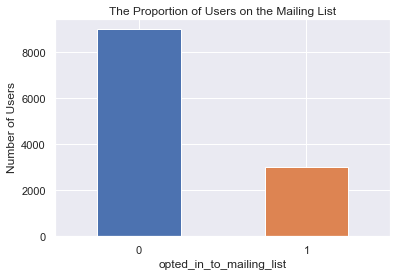

In [24]:
_ = plot_bars(users_df, 'opted_in_to_mailing_list', None)

_ = plt.ylabel('Number of Users')
_ = plt.title('The Proportion of Users on the Mailing List')

plt.show()

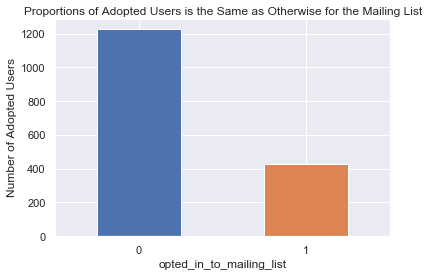

In [25]:
_ = plot_bars(users_df, 'opted_in_to_mailing_list', 'adopted')

_ = plt.ylabel('Number of Adopted Users')
_ = plt.title('Proportions of Adopted Users is the Same as Otherwise for the Mailing List')

plt.show()

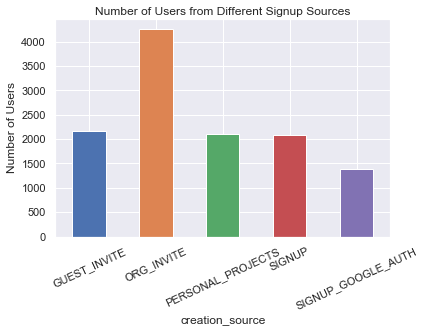

In [26]:
_ = plot_bars(users_df, 'creation_source', None, 25)

_ = plt.title('Number of Users from Different Signup Sources')
_ = plt.ylabel('Number of Users')

plt.show()

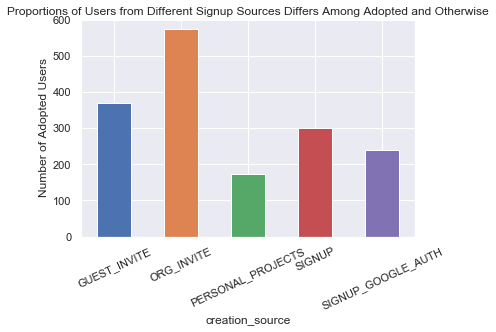

In [27]:
_ = plot_bars(users_df, 'creation_source', 'adopted', 25)

_ = plt.title('Proportions of Users from Different Signup Sources Differs Among Adopted and Otherwise')
_ = plt.ylabel('Number of Adopted Users')

plt.show()

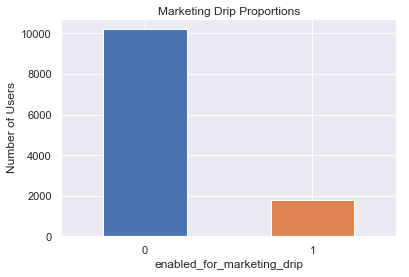

In [28]:
_ = plot_bars(users_df, 'enabled_for_marketing_drip', None)

_ = plt.title('Marketing Drip Proportions')
_ = plt.ylabel('Number of Users')

plt.show()

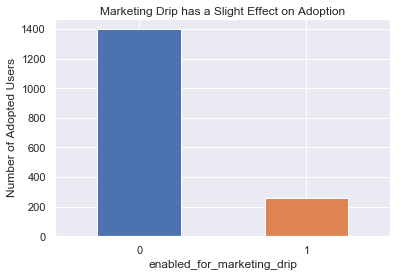

In [29]:
_ = plot_bars(users_df, 'enabled_for_marketing_drip', 'adopted')

_ = plt.title('Marketing Drip has a Slight Effect on Adoption')
_ = plt.ylabel('Number of Adopted Users')

plt.show()

### Model Selection

Since we are predicting a binary outcome, I would rather use logistic regression. It is easy, accurate, and interpretable.

Predict which factors will be the most important for a user to be adopted

In [30]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0


In [31]:
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


#### Feature Engineering

Put a column for how many logins each user has

Any feature involving time?

In [32]:
user_engagement_df[user_engagement_df['user_id'] == 2]['visited'].sum()

14

In [33]:
users_df.loc[:, 'logins'] = [user_engagement_df[user_engagement_df['user_id'] == obj_id]['visited'].sum()
                             for obj_id in users_df['object_id']]

In [34]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,logins
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,14
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0,1


Keep only the relevant numerical columns

Get the predictor column and set it as y

In [79]:
x_cols = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'logins']
X = users_df[x_cols]
X = pd.get_dummies(X, columns=['creation_source'])

In [80]:
y = users_df['adopted']

Rescale the data

In [81]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [82]:
X_scaled.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,logins,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,0.028591,0.180250,0.354500,0.175917,0.173917,0.115417
std,0.432742,0.356432,0.106086,0.384412,0.478381,0.380765,0.379054,0.319537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.001650,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.001650,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Run the logistic regression

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=6,
                                                    stratify=y)

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.931944444444


That is an incredible accuracy for the base logistic regression model.

Let's do some hyperparameter tuning.

In [85]:
from sklearn.model_selection import GridSearchCV

params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'fit_intercept': [True, False]
}

lr_gridsearch = GridSearchCV(LogisticRegression(random_state=6),
                             param_grid=params,
                             cv=5,
                             return_train_score=True)

lr_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=6, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10.0], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [86]:
lr_gridsearch.best_score_

0.98416666666666663

In [87]:
lr_gridsearch.best_estimator_

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=6, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [88]:
y_pred = lr_gridsearch.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.982777777778


This is even more incredible. Let's look at the feature coefficients.

### Model Evaluation

The accuracy of the LR models were all above 90%. Interestingly enough, the best penalty term was l1. 

In [89]:
lr_coefs_df = pd.DataFrame({'stock_model': lr_model.coef_[0],
                            'cv_model': lr_gridsearch.best_estimator_.coef_[0]},
                            index=X.columns.values)
lr_coefs_df

,cv_model,stock_model
opted_in_to_mailing_list,-0.077659,-0.057084
enabled_for_marketing_drip,0.000000,0.095579
logins,530.623591,23.728211
creation_source_GUEST_INVITE,-0.194267,-0.206716
creation_source_ORG_INVITE,-0.059538,-0.401423
creation_source_PERSONAL_PROJECTS,0.208364,-0.836862
creation_source_SIGNUP,0.000000,-0.408407
creation_source_SIGNUP_GOOGLE_AUTH,-0.122130,-0.281492


That is a feature coefficient of 530. Oh my.

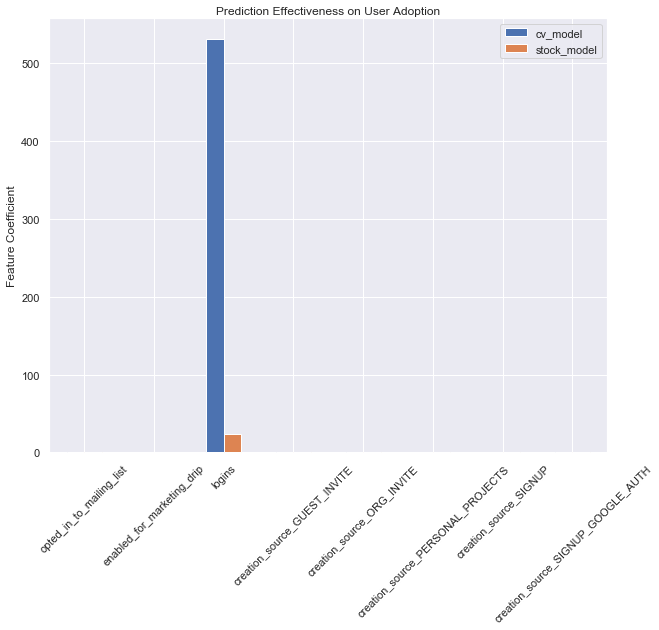

In [90]:
plt.rcParams["figure.figsize"] = (10, 8)
_ = lr_coefs_df.plot.bar(rot=45)
_ = plt.ylabel('Feature Coefficient')
_ = plt.title('Prediction Effectiveness on User Adoption')

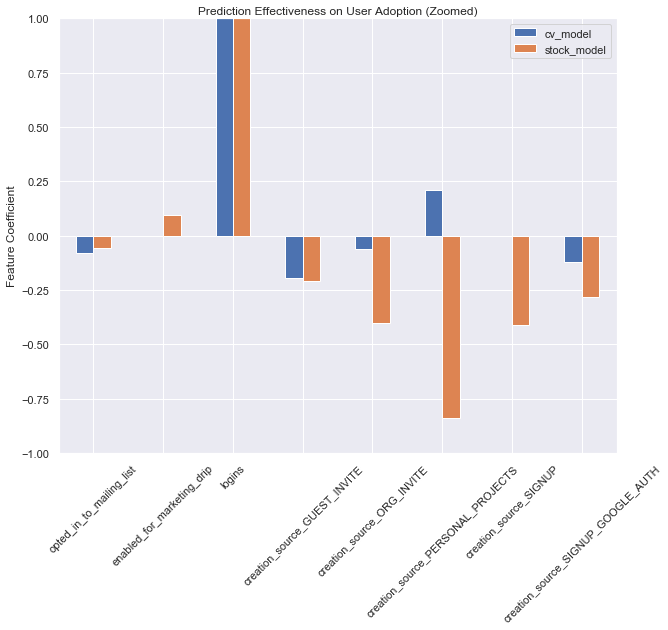

In [91]:
plt.rcParams["figure.figsize"] = (10, 8)
_ = lr_coefs_df.plot.bar(rot=45)
_ = plt.ylabel('Feature Coefficient')
_ = plt.title('Prediction Effectiveness on User Adoption (Zoomed)')
_ = plt.ylim([-1, 1])

The overwhelmingly most important feature for user adoption is how many times they log in.

The models differ on what else they consider is important (might be overfitting, but the accuracy score suggests otherwise).

Let's take the login column out of the data and rerun the analysis.

In [92]:
X = X.drop(columns=['logins'])
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


In [93]:
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=6,
                                                    stratify=y)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.861944444444


C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [101]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1.0, 10.0],
    'fit_intercept': [True, False]
}

lr_gridsearch_2 = GridSearchCV(LogisticRegression(random_state=6),
                             param_grid=params,
                             cv=5,
                             return_train_score=True)

lr_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=6, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1.0, 10.0], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [102]:
lr_gridsearch.best_score_

0.86202380952380953

In [103]:
lr_gridsearch.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=6, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [104]:
y_pred = lr_gridsearch.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.861944444444


In [105]:
lr_gridsearch.best_estimator_.coef_

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

I don't know why there are no coefficients....

In [106]:
lr_coefs_df = pd.DataFrame({'stock_model': lr_model.coef_[0],
                            'cv_model': lr_gridsearch.best_estimator_.coef_[0]},
                            index=X.columns.values)
lr_coefs_df

,cv_model,stock_model
opted_in_to_mailing_list,0.0,0.047843
enabled_for_marketing_drip,0.0,0.042088
creation_source_GUEST_INVITE,0.0,-0.088345
creation_source_ORG_INVITE,0.0,-0.320654
creation_source_PERSONAL_PROJECTS,0.0,-0.849349
creation_source_SIGNUP,0.0,-0.259283
creation_source_SIGNUP_GOOGLE_AUTH,0.0,-0.028190


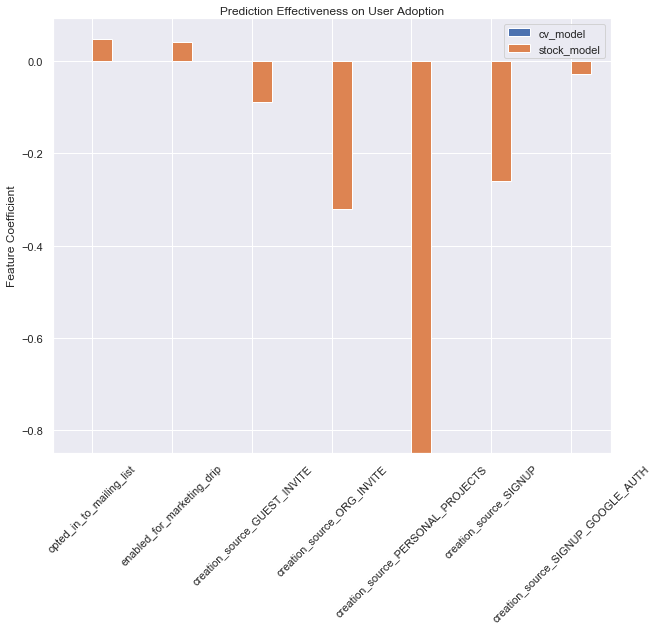

In [100]:
plt.rcParams["figure.figsize"] = (10, 8)
_ = lr_coefs_df.plot.bar(rot=45)
_ = plt.ylabel('Feature Coefficient')
_ = plt.title('Prediction Effectiveness on User Adoption')

The base logistic regression has coefficients that tell us something.

Users who sign up to do personal projects are much less likely to become adopted users.

Users who are invited through organizational invites or normal signups are less likely to become adopted users.

Being on the mailing list or the marketing drip can slightly boost user adoption rates.